In [48]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Minimum Variance Portfolio Backtest.

In [49]:
import pandas as pd
from qamsi.config.trading_config import TradingConfig
from qamsi.runner import Runner
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from qamsi.features.preprocessor import Preprocessor
from run import Dataset

In [50]:
REBAL_FREQ = "ME"
DATASET = Dataset.SPX_US
ESTIMATION_WINDOW = 365 * 1

In [51]:
experiment_config = DATASET.value()

stocks = tuple(
    pd.read_csv(experiment_config.PATH_OUTPUT / experiment_config.STOCKS_LIST_FILENAME)
    .iloc[:, 0]
    .astype(str)
    .tolist(),
)
experiment_config.ASSET_UNIVERSE = stocks  # type: ignore  # noqa: PGH003

experiment_config.MIN_ROLLING_PERIODS = ESTIMATION_WINDOW + 1
experiment_config.N_LOOKBEHIND_PERIODS = None
experiment_config.REBALANCE_FREQ = REBAL_FREQ

factors = pd.read_csv(experiment_config.PATH_OUTPUT / "factors.csv")
factors["date"] = pd.to_datetime(factors["date"])
factors = factors.set_index("date")
factor_names = tuple(factors.columns.astype(str).tolist())
experiment_config.FACTORS = factor_names

prices = [stock + "_Price" for stock in list(stocks)]
preprocessor = Preprocessor(
    exclude_names=[
        *list(stocks),
        experiment_config.RF_NAME,
        *experiment_config.HEDGING_ASSETS,
        *factor_names,
        *prices,
    ],
)

trading_config = TradingConfig(
    broker_fee=0.05 / 100,
    bid_ask_spread=0.03 / 100,
    total_exposure=1,
    max_exposure=1,
    min_exposure=0,
    trading_lag_days=1,
)

runner = Runner(
    experiment_config=experiment_config,
    trading_config=trading_config,
    verbose=True,
)

Backtest on 2004-03-19 00:00:00 to 2023-12-29 00:00:00


In [52]:
ESTIMATOR = CovEstimators.GPR.value(shrinkage_type="linear")

strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Num Train Iterations: 221


Computing Weights: 100%|██████████| 221/221 [00:39<00:00,  5.57it/s]


StrategyStatistics:
* final_nav = 4.245406
* geom_avg_total_r = 0.102707
* geom_avg_xs_r = 0.067666
* std_xs_r = 0.137249
* min_xs_r = -0.090083
* max_xs_r = 0.087080
* skew = -0.264332
* kurtosis = 24.517129
* max_dd = -0.306150
* sharpe = 0.493017
* alpha_buy_hold = 0.005417
* tracking_error_buy_hold = 0.130770
* ir_buy_hold = 0.041427
* factor_loadings = {'low_risk': 0.4346993112610487, 'momentum': 0.011580032081507234, 'quality': -0.023277006512330754, 'size': 0.0846294804069751, 'value': -0.08744564934767297, 'spx': 0.6857765164662377}
* alpha_benchmark = 0.016146
* alpha_benchmark_pvalue = 0.326438
* tracking_error_benchmark = 0.066337
* ir_benchmark = 0.243392
* ttest_pval = 0.557560
* levene_pval = 0.000000
* timing_ability_coef = -0.025897
* timing_ability_pval = 0.054753

In [53]:
result.std_xs_r

np.float64(0.13724910426105155)

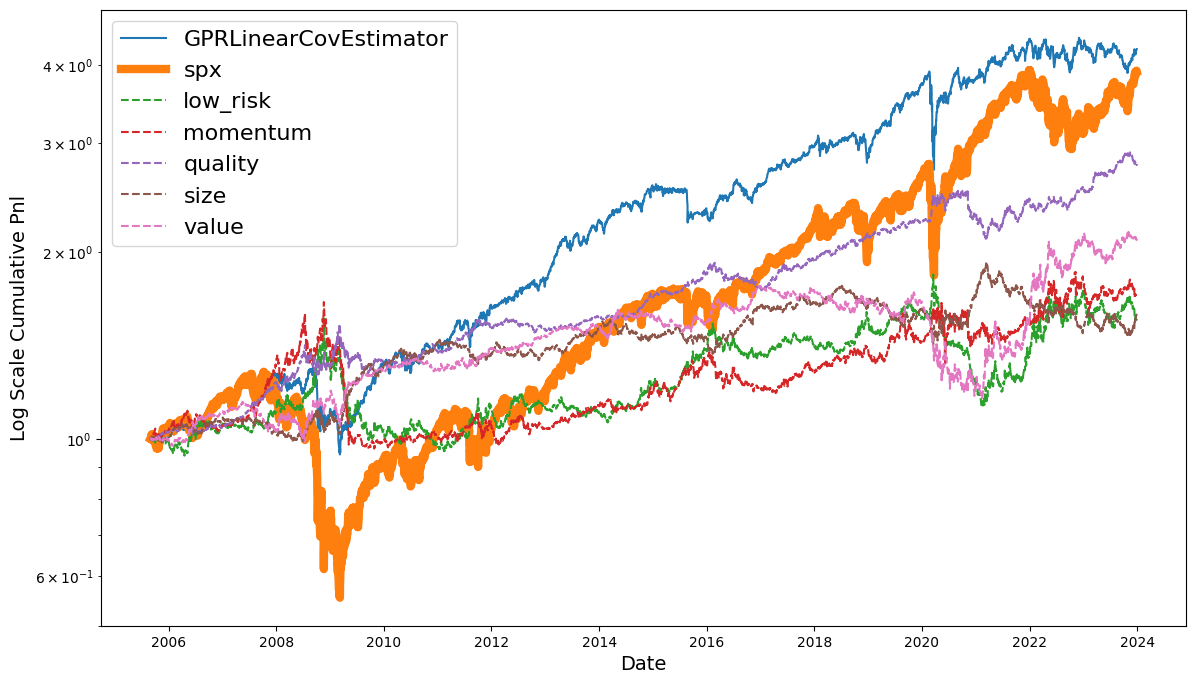

In [54]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

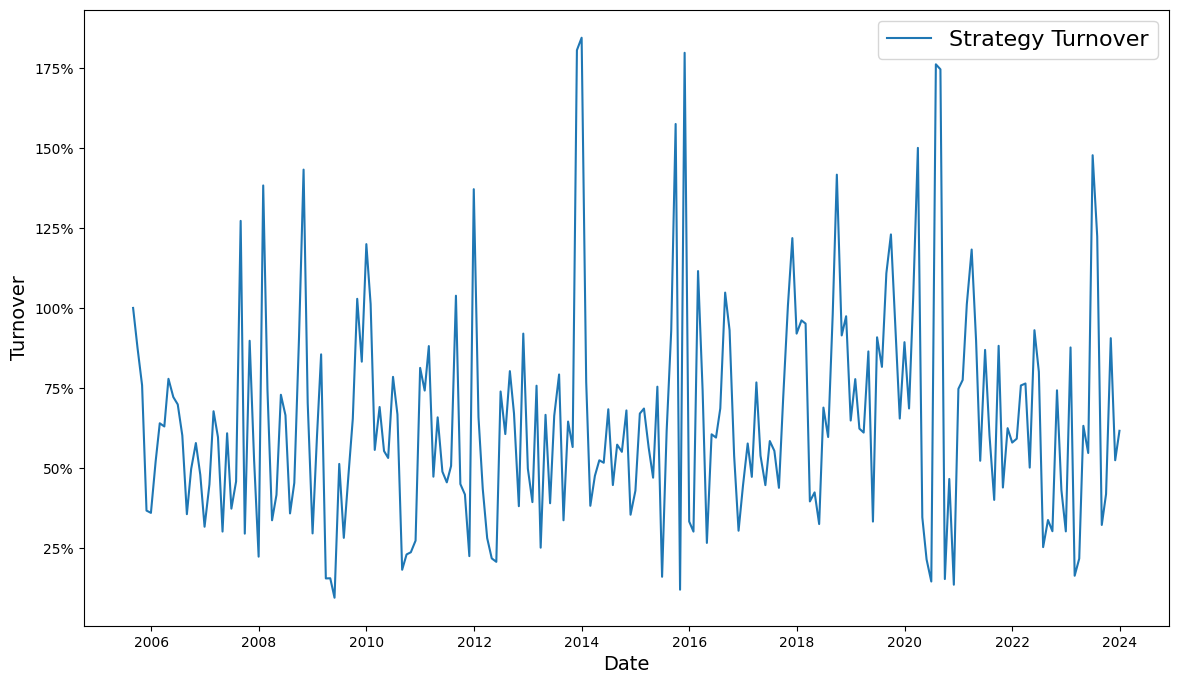

In [55]:
runner.plot_turnover()

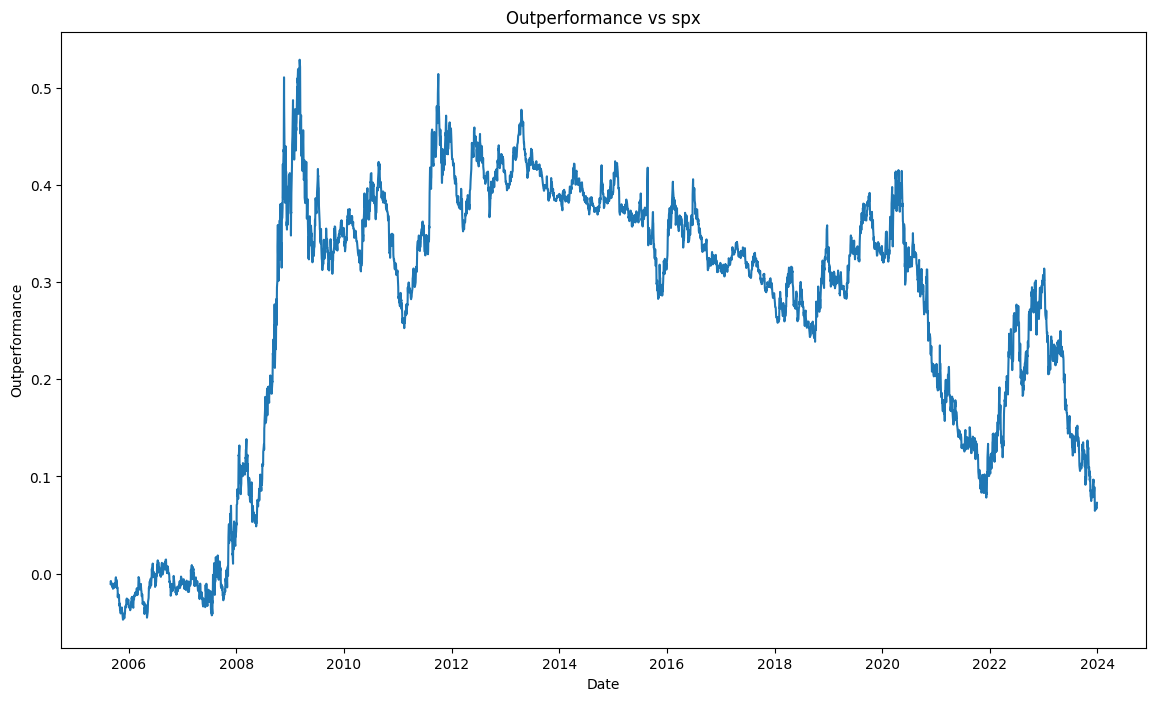

In [56]:
runner.plot_outperformance(mkt_only=True)

In [57]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")

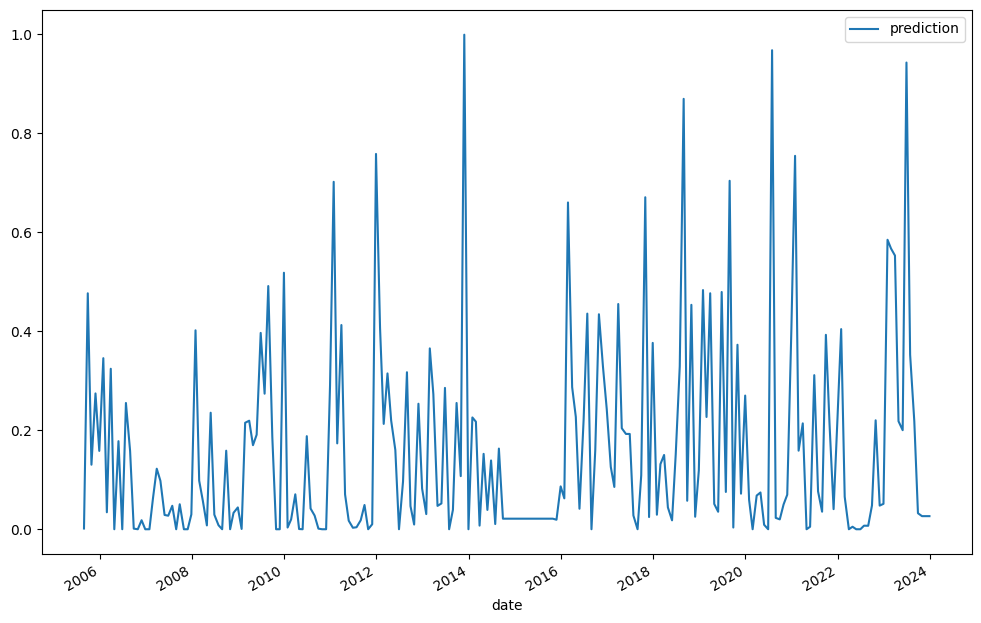

In [58]:
ESTIMATOR.predictions.plot(figsize=(12, 8));

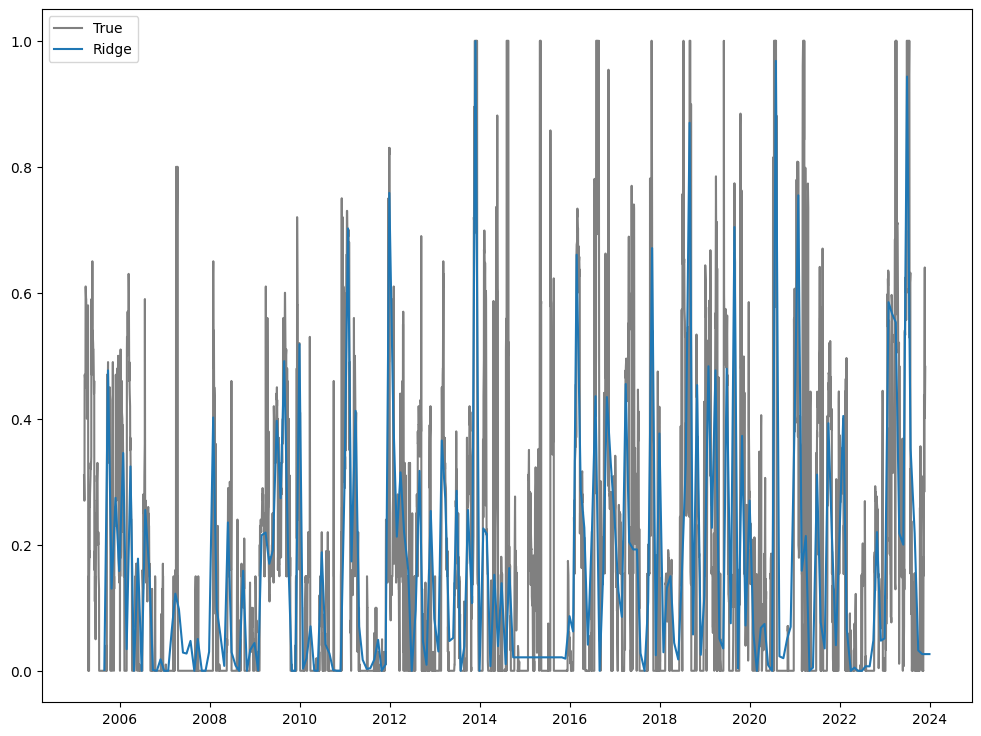

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(
    runner.targets.index, runner.targets["l_shrinkage"], label="True", color="grey"
)
plt.plot(ESTIMATOR.predictions.index, ESTIMATOR.predictions.to_numpy(), label="Ridge")
# plt.plot(runner.features.index, runner.features["l_shrinkage_feat"].shift(1), label="MA")

plt.legend()
plt.show()

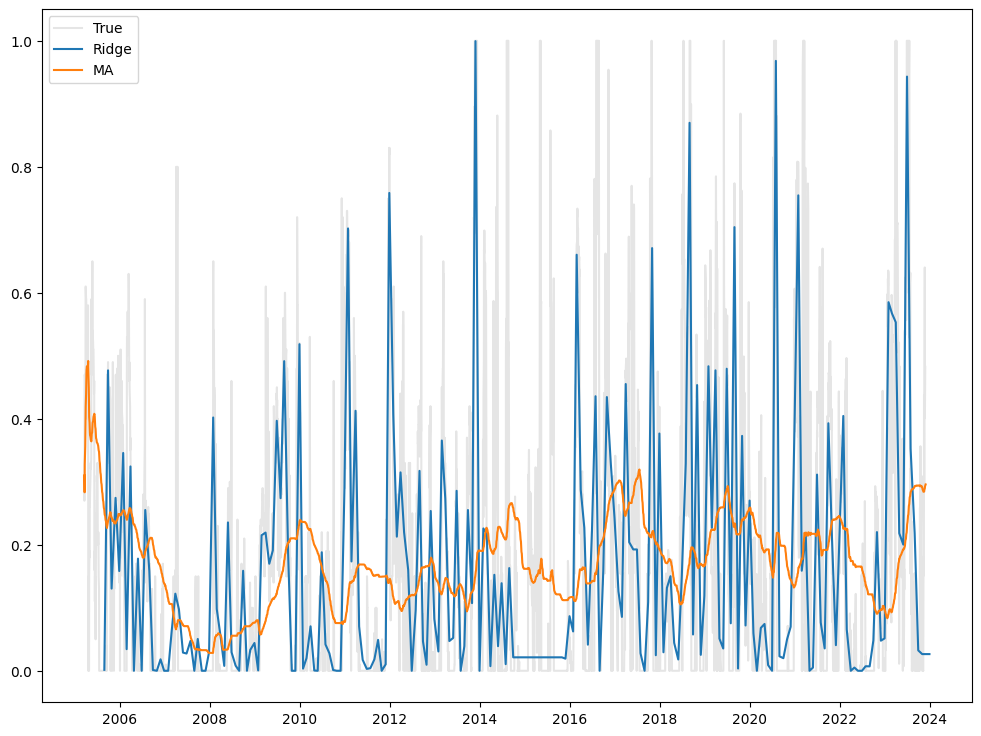

In [66]:
plt.figure(figsize=(12, 9))

ma = runner.features["l_shrinkage_mu"].shift(1)

plt.plot(
    runner.targets.index,
    runner.targets["l_shrinkage"],
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(ESTIMATOR.predictions.index, ESTIMATOR.predictions.to_numpy(), label="Ridge")
plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

In [61]:
runner.features["l_shrinkage_feat"]

date
2004-03-19   NaN
2004-03-22   NaN
2004-03-23   NaN
2004-03-24   NaN
2004-03-25   NaN
              ..
2023-12-22   NaN
2023-12-26   NaN
2023-12-27   NaN
2023-12-28   NaN
2023-12-29   NaN
Name: l_shrinkage_feat, Length: 4980, dtype: float64

In [62]:
runner.targets["l_shrinkage"]

date
2004-03-19   NaN
2004-03-22   NaN
2004-03-23   NaN
2004-03-24   NaN
2004-03-25   NaN
              ..
2023-12-22   NaN
2023-12-26   NaN
2023-12-27   NaN
2023-12-28   NaN
2023-12-29   NaN
Name: l_shrinkage, Length: 4980, dtype: float64